#NNDL-HW4-Q1
Nadafi-Forouzesh

import libraries

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras import Model
import tensorflow as tf
from keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense,Dropout,Activation,BatchNormalization,Conv1D,MaxPooling1D,Flatten
from keras.layers import LSTM
from google.colab import drive
drive.mount('/content/drive')
import glob
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install tensorflow-addons
from tensorflow_addons.metrics import RSquare

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 28.2 MB/s 


# Dataset



In [3]:
csvs = glob.glob('/content/drive/MyDrive/Colab Notebooks/PRSA_Data_20130301-20170228/**.csv')
print("There are totatl {} csv files in the given dataset".format(len(csvs)))

There are totatl 12 csv files in the given dataset


# Preprocessing

In [4]:
dataFrames = []
for i in range(12):
    df = pd.read_csv(csvs[i], index_col=None, header=0) #read each CSV file
    df = df.interpolate(method ='linear', limit_direction ='forward') # Insertion of missing values by Linear Interpolation method
#--------------------------collect PM2.5 from all dataset and important column from Aotizhongxin-------------------------------
    if i == 0 :
      #print(df['wd'].unique())
#--------------------------------------------Encoding Categorical Variable-----------------------------------------------------
      WD = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE'
            , 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
      degree = []
      for i in range(len(WD)):
        degree.append (i*22.5)
      print(WD,'\n',degree)
      for i in range(len(WD)):
        df['wd'] = df['wd'].replace(to_replace=WD[i] ,value=degree[i])# replace wd with degree values
#---------------------------------------------Missing value-------------------------------------------------------------------
      df = df.interpolate(method ='linear', limit_direction ='forward') # Insertion of missing values by Linear Interpolation method
      dataFrames.append(df)
    else :
      df = df.interpolate(method ='linear', limit_direction ='forward') # Insertion of missing values by Linear Interpolation method
      newname = 'PM2.5-' + df.iloc[1,17]
      df = df.rename(columns={ 'PM2.5': str(newname) })
      dataFrames.append(df[newname])
data = pd.concat(dataFrames,axis=1)
data = data.drop(columns=['No', 'year', 'month', 'day', 'hour', 'SO2', 'NO2', 'O3', 'station'])#delete unnecessary columns

['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW'] 
 [0.0, 22.5, 45.0, 67.5, 90.0, 112.5, 135.0, 157.5, 180.0, 202.5, 225.0, 247.5, 270.0, 292.5, 315.0, 337.5]


In [39]:
data.isna().sum()

PM2.5                  0
PM10                   0
CO                     0
TEMP                   0
PRES                   0
DEWP                   0
RAIN                   0
wd                     0
WSPM                   0
PM2.5-Changping        0
PM2.5-Dingling         0
PM2.5-Dongsi           0
PM2.5-Guanyuan         0
PM2.5-Gucheng          0
PM2.5-Huairou          0
PM2.5-Nongzhanguan     0
PM2.5-Shunyi           0
PM2.5-Tiantan          0
PM2.5-Wanliu           0
PM2.5-Wanshouxigong    0
dtype: int64

In [5]:
#---------------------------------------- Pearson Correlation ------------------------------------------------------------------------------------
corr=data.corr(method = 'pearson').round(2)
heatmap=corr.drop(['PM10', 'CO', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM']).drop(['PM10', 'CO', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM'],axis=1)
heatmap.style.background_gradient(cmap='OrRd')

,PM2.5,PM2.5-Changping,PM2.5-Dingling,PM2.5-Dongsi,PM2.5-Guanyuan,PM2.5-Gucheng,PM2.5-Huairou,PM2.5-Nongzhanguan,PM2.5-Shunyi,PM2.5-Tiantan,PM2.5-Wanliu,PM2.5-Wanshouxigong
PM2.5,1.000000,0.840000,0.820000,0.950000,0.950000,0.900000,0.850000,0.940000,0.890000,0.930000,0.940000,0.920000
PM2.5-Changping,0.840000,1.000000,0.910000,0.820000,0.840000,0.850000,0.850000,0.810000,0.810000,0.810000,0.870000,0.790000
PM2.5-Dingling,0.820000,0.910000,1.000000,0.800000,0.820000,0.830000,0.850000,0.790000,0.800000,0.780000,0.840000,0.770000
PM2.5-Dongsi,0.950000,0.820000,0.800000,1.000000,0.960000,0.900000,0.830000,0.960000,0.880000,0.960000,0.930000,0.950000
PM2.5-Guanyuan,0.950000,0.840000,0.820000,0.960000,1.000000,0.920000,0.850000,0.950000,0.880000,0.950000,0.950000,0.950000
PM2.5-Gucheng,0.900000,0.850000,0.830000,0.900000,0.920000,1.000000,0.860000,0.880000,0.860000,0.890000,0.930000,0.890000
PM2.5-Huairou,0.850000,0.850000,0.850000,0.830000,0.850000,0.860000,1.000000,0.820000,0.890000,0.820000,0.850000,0.810000
PM2.5-Nongzhanguan,0.940000,0.810000,0.790000,0.960000,0.950000,0.880000,0.820000,1.000000,0.880000,0.950000,0.920000,0.940000
PM2.5-Shunyi,0.890000,0.810000,0.800000,0.880000,0.880000,0.860000,0.890000,0.880000,1.000000,0.880000,0.870000,0.870000
PM2.5-Tiantan,0.930000,0.810000,0.780000,0.960000,0.950000,0.890000,0.820000,0.950000,0.880000,1.000000,0.920000,0.960000


In [6]:
#--------------------------------------- Save 20 important features as 20features.csv file ----------------------------------------------------------
filepath = Path('/content/drive/MyDrive/Colab Notebooks/20features.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
data.to_csv(filepath) 

# 1 day lag

In [7]:
#------------------------------------------------------------ Supervised dataset --------------------------------------------------------------------
#-------------------------------------- Normalization ----------------------------------------------------------------------------------------------
#Scaler = MinMaxScaler()
#datac = data.values
#datac = Scaler.fit_transform(datac)

for feature in data.columns:
  maxf = data[feature].max()
  minf = data[feature].min()
  data[feature] = (data[feature] - minf) / (maxf - minf) #minmax Normalization


datac = data.values
d=np.zeros((35040,24,20)) # split to 1day lag
label = []

for i in range(35040):
    label.append(datac[i+24,0])
    d[i,0:24,:] = datac[i:i+24,:]

label = np.array(label)
X_train, X_test, y_train, y_test = train_test_split(d, label, test_size=0.2, shuffle=False)



#X_train = Scaler.fit_transform(X_train[:,:,all])
#X_test = Scaler.transform(X_test)
#test_size = 7008

#datac_train = d[:-test_size]
#datac_test = d[-test_size:]
#label_train = label[:-test_size]
#label_test = label[-test_size:]


print(X_train.shape)
print(y_train.shape)

(28032, 24, 20)
(28032,)


In [6]:
#-----------------------------------------------------Define Model--------------------------------
model = Sequential()

# 1st Conv-Block
model.add(Conv1D(64, kernel_size=3, input_shape = (24,20), padding='causal'))
model.add(Activation('relu'))
model.add(BatchNormalization())

# 2nd Conv-Block
model.add(Conv1D(64,kernel_size=3, padding='causal'))
model.add(Activation('relu'))
model.add(BatchNormalization())

# 3rd Conv-Block
model.add(Conv1D(32,kernel_size=3, padding='causal'))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=3))

#LSTM blockes
model.add(LSTM(100, dropout=0.2 , return_sequences=True))
model.add(LSTM(50, dropout=0.3))

# Classification Block 
model.add(Dense(1 , activation='relu')) 


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 24, 64)            3904      
                                                                 
 activation_3 (Activation)   (None, 24, 64)            0         
                                                                 
 batch_normalization_2 (Batc  (None, 24, 64)           256       
 hNormalization)                                                 
                                                                 
 conv1d_4 (Conv1D)           (None, 24, 64)            12352     
                                                                 
 activation_4 (Activation)   (None, 24, 64)            0         
                                                                 
 batch_normalization_3 (Batc  (None, 24, 64)           256       
 hNormalization)                                      

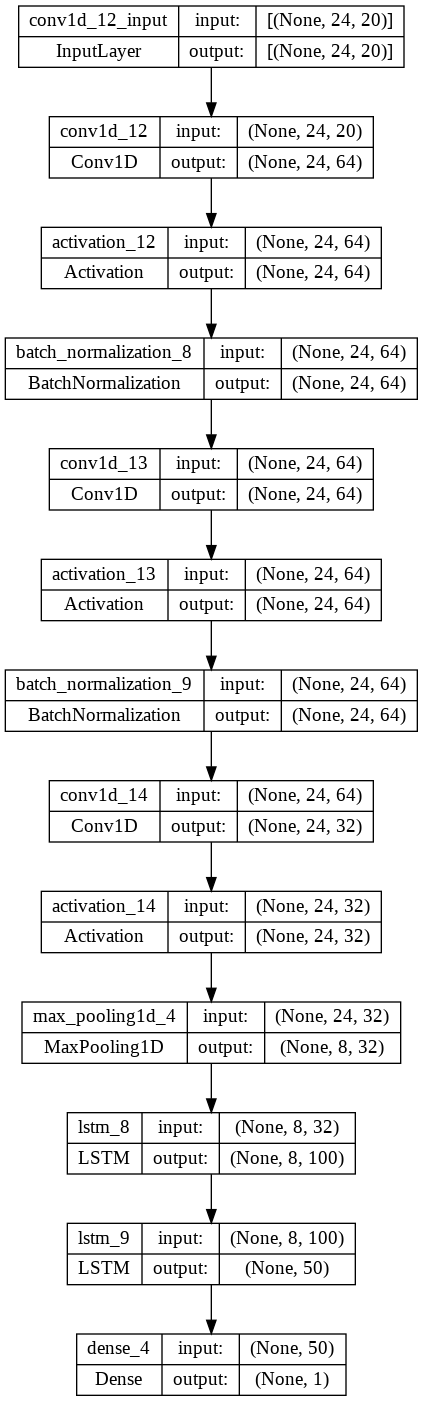

In [63]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
#callback = tf.keras.callbacks.EarlyStopping( min_delta = 1e-3, patience = 50, restore_best_weights=True)
model.compile(loss='mse',optimizer=tf.optimizers.Adam(learning_rate=0.001, decay=0.0001),metrics=[tf.keras.losses.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()]) 
fitting=model.fit(X_train, y_train, batch_size=32, epochs=200 , verbose=2,  validation_split=0.2)#callbacks=[callback],

In [10]:
predicted_y = model.predict(X_test).flatten()

219/219 [==============================] - 1s 3ms/step


In [11]:
print("R2: " + str(RSquare()(y_test, predicted_y).numpy()))
print("MAE: " + str(tf.keras.losses.MeanAbsoluteError()(y_test, predicted_y).numpy()))
print("RMSE: " + str(tf.keras.metrics.RootMeanSquaredError()(y_test, predicted_y).numpy()))

R2: 0.9354158
MAE: 0.014311018
RMSE: 0.023742381


# 7 days lag

In [8]:
del model

In [9]:
#------------------------------------------------------------ Supervised dataset --------------------------------------------------------------------
#-------------------------------------- Normalization ----------------------------------------------------------------------------------------------
#Scaler = MinMaxScaler()
#datac = data.values
#datac = Scaler.fit_transform(datac)

for feature in data.columns:
  maxf = data[feature].max()
  minf = data[feature].min()
  data[feature] = (data[feature] - minf) / (maxf - minf) #minmax Normalization


datac = data.values
d=np.zeros((34896,168,20)) # split to 1day lag
label = []

for i in range(34896):
    label.append(datac[i+168,0])
    d[i,0:168,:] = datac[i:i+168,:]

label = np.array(label)
X_train, X_test, y_train, y_test = train_test_split(d, label, test_size=0.2, shuffle=False)



#X_train = Scaler.fit_transform(X_train[:,:,all])
#X_test = Scaler.transform(X_test)
#test_size = 7008

#datac_train = d[:-test_size]
#datac_test = d[-test_size:]
#label_train = label[:-test_size]
#label_test = label[-test_size:]


print(X_train.shape)
print(y_train.shape)

(27916, 168, 20)
(27916,)


In [10]:
model = Sequential()

# 1st Conv-Block
model.add(Conv1D(64, kernel_size=3, input_shape = (168,20), padding='causal'))
model.add(Activation('relu'))
model.add(BatchNormalization())

# 2nd Conv-Block
model.add(Conv1D(64,kernel_size=3, padding='causal'))
model.add(Activation('relu'))
model.add(BatchNormalization())

# 3rd Conv-Block
model.add(Conv1D(32,kernel_size=3, padding='causal'))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=3))

#LSTM blockes
model.add(LSTM(100, dropout=0.2 , return_sequences=True))
model.add(LSTM(50, dropout=0.3))

# Classification Block 
model.add(Dense(1 , activation='relu')) 


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 168, 64)           3904      
                                                                 
 activation_3 (Activation)   (None, 168, 64)           0         
                                                                 
 batch_normalization_2 (Batc  (None, 168, 64)          256       
 hNormalization)                                                 
                                                                 
 conv1d_4 (Conv1D)           (None, 168, 64)           12352     
                                                                 
 activation_4 (Activation)   (None, 168, 64)           0         
                                                                 
 batch_normalization_3 (Batc  (None, 168, 64)          256       
 hNormalization)                                      

In [11]:
#callback = tf.keras.callbacks.EarlyStopping( min_delta = 1e-3, patience = 50, restore_best_weights=True)
model.compile(loss='mse',optimizer=tf.optimizers.Adam(learning_rate=0.001, decay=0.0001),metrics=[tf.keras.losses.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()]) 
fitting=model.fit(X_train, y_train, batch_size=32, epochs=200 , verbose=2,  validation_split=0.2)#callbacks=[callback],

Epoch 1/200
698/698 - 12s - loss: 0.0031 - mean_absolute_error: 0.0362 - root_mean_squared_error: 0.0553 - val_loss: 0.0021 - val_mean_absolute_error: 0.0275 - val_root_mean_squared_error: 0.0454 - 12s/epoch - 17ms/step
Epoch 2/200
698/698 - 7s - loss: 0.0010 - mean_absolute_error: 0.0215 - root_mean_squared_error: 0.0317 - val_loss: 0.0011 - val_mean_absolute_error: 0.0180 - val_root_mean_squared_error: 0.0336 - 7s/epoch - 11ms/step
Epoch 3/200
698/698 - 8s - loss: 8.0826e-04 - mean_absolute_error: 0.0193 - root_mean_squared_error: 0.0284 - val_loss: 9.9429e-04 - val_mean_absolute_error: 0.0185 - val_root_mean_squared_error: 0.0315 - 8s/epoch - 12ms/step
Epoch 4/200
698/698 - 7s - loss: 7.1594e-04 - mean_absolute_error: 0.0178 - root_mean_squared_error: 0.0268 - val_loss: 8.0740e-04 - val_mean_absolute_error: 0.0168 - val_root_mean_squared_error: 0.0284 - 7s/epoch - 11ms/step
Epoch 5/200
698/698 - 8s - loss: 6.3644e-04 - mean_absolute_error: 0.0168 - root_mean_squared_error: 0.0252 - 

In [12]:
predicted_y = model.predict(X_test).flatten()
print("R2: " + str(RSquare()(y_test, predicted_y).numpy()))
print("MAE: " + str(tf.keras.losses.MeanAbsoluteError()(y_test, predicted_y).numpy()))
print("RMSE: " + str(tf.keras.metrics.RootMeanSquaredError()(y_test, predicted_y).numpy()))

219/219 [==============================] - 2s 5ms/step
R2: 0.93712753
MAE: 0.014506426
RMSE: 0.023458716
